In [19]:
# --- Dataset Setup ---
from google.colab import files
import pandas as pd
import numpy as np

print("Please upload your CSV file (census.csv):")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Read CSV without headers
data = pd.read_csv(filename, header=None)

# Assign headers
data.columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

# Strip whitespace from all string columns
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].str.strip()

# Quick check
print("Dataset loaded successfully:", data.shape)
data.head()


Please upload your CSV file (census.csv):


Saving census.csv to census (6).csv
Dataset loaded successfully: (32561, 15)


age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

In [20]:
# Number of records
num_records = data.shape[0]

# Number of people with income >50K / <=50K
num_income_gt_50k = (data['income'] == '>50K').sum()
num_income_le_50k = (data['income'] == '<=50K').sum()
pct_income_gt_50k = (num_income_gt_50k / num_records) * 100

print("Number of records:", num_records)
print("Number of individuals with income >50K:", num_income_gt_50k)
print("Number of individuals with income <=50K:", num_income_le_50k)
print("Percentage of individuals with income >50K: {:.2f}%".format(pct_income_gt_50k))


Number of records: 32561
Number of individuals with income >50K: 7841
Number of individuals with income <=50K: 24720
Percentage of individuals with income >50K: 24.08%


In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Separate features and target
X = data.drop('income', axis=1)
y = data['income']

# Encode categorical features
categorical_features = X.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_features]),
                         columns=encoder.get_feature_names_out(categorical_features))

# Numeric features
X_numeric = X.select_dtypes(include=[np.number])

# Combine numeric + encoded
X_preprocessed = pd.concat([X_numeric.reset_index(drop=True),
                            X_encoded.reset_index(drop=True)], axis=1)

# Encode target
y_encoded = y.map({'>50K': 1, '<=50K': 0})

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y_encoded, test_size=0.2, random_state=42
)

print("Preprocessing complete. Training shape:", X_train.shape)


Preprocessing complete. Training shape: (26048, 100)


In [22]:
from sklearn.metrics import accuracy_score, f1_score

# Naive predictor: predict everyone earns >50K
y_naive_pred = np.ones_like(y_test)

accuracy_naive = accuracy_score(y_test, y_naive_pred)
f1_naive = f1_score(y_test, y_naive_pred)

print("Naive Predictor Accuracy:", accuracy_naive)
print("Naive Predictor F1 Score:", f1_naive)


Naive Predictor Accuracy: 0.24120988791647474
Naive Predictor F1 Score: 0.38866897575457693


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Fit, predict, and evaluate each model
for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))



--- Logistic Regression ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4942
           1       0.73      0.58      0.65      1571

    accuracy                           0.85      6513
   macro avg       0.80      0.75      0.77      6513
weighted avg       0.84      0.85      0.84      6513


--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4942
           1       0.62      0.64      0.63      1571

    accuracy                           0.82      6513
   macro avg       0.75      0.76      0.75      6513
weighted avg       0.82      0.82      0.82      6513


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4942
           1       0.74      0.63      0.68      1571

    accuracy                           0.86      6513
   macro avg       0.82      0.78      0.80      6513
weighted avg       0.85     

Top 10 feature importances:
 fnlwgt                               0.160329
age                                  0.151932
capital-gain                         0.100276
hours-per-week                       0.082777
marital-status_Married-civ-spouse    0.076892
education-num                        0.064186
marital-status_Never-married         0.031146
capital-loss                         0.030441
sex_Male                             0.019844
occupation_Exec-managerial           0.019295
dtype: float64


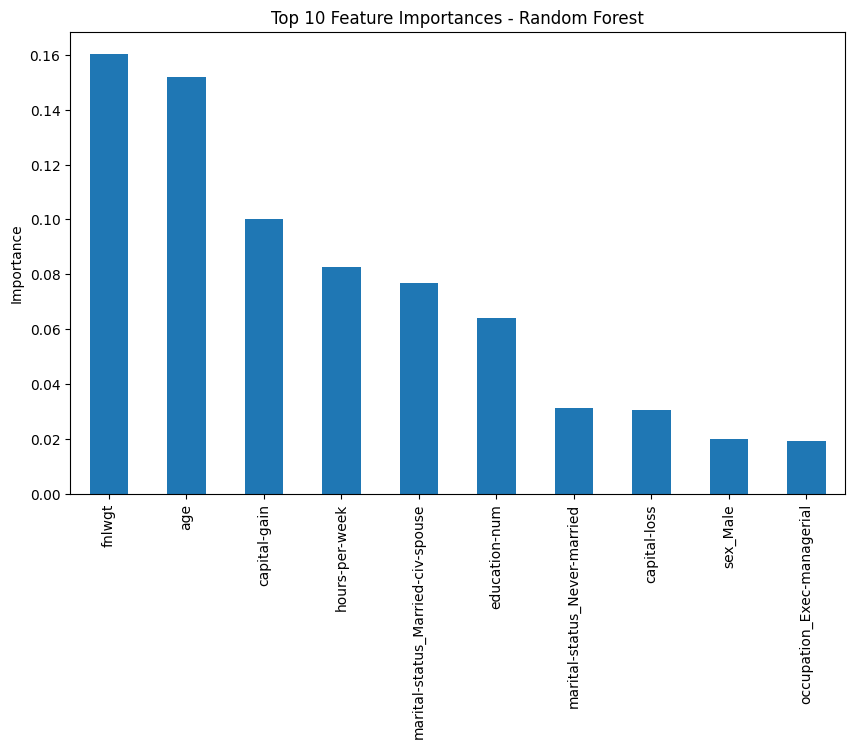

In [24]:
import matplotlib.pyplot as plt

# Using Random Forest for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
features = X_preprocessed.columns

# Top 10 features
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False).head(10)
print("Top 10 feature importances:\n", feat_imp)

# Plot
plt.figure(figsize=(10,6))
feat_imp.plot(kind='bar')
plt.title("Top 10 Feature Importances - Random Forest")
plt.ylabel("Importance")
plt.show()


In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1')
grid_rf.fit(X_train, y_train)

print("Best Parameters:", grid_rf.best_params_)
print("Best F1 Score on training set:", grid_rf.best_score_)


Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Best F1 Score on training set: 0.6787401605242325
